## Unsupervised learning

This dataset is from the US Arrests Kaggle challenge https://www.kaggle.com/datasets/kurohana/usarrets). A description of the
data is given as: “This data set contains statistics, in arrests per 100,000 residents,
for assault, murder, and rape in each of the 50 US states in 1973. Also given is the
percent of the population living in urban areas.”

## Exploring the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("UsArrests.csv", index_col='City')
df.head()


,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [2]:
print('Number of data entries: {} Number of features: {}'.format(df.shape[0],df.shape[1]))

Number of data entries: 50 Number of features: 4


First, view the summary statistics of the data

In [3]:
# View summary statistics of the data
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.788,4.355510,0.8,17.4
Assault,170.760,83.337661,45.0,337.0
UrbanPop,65.540,14.474763,32.0,91.0
Rape,21.232,9.366385,7.3,46.0


Check data type to ensure that all features can be modified if need be with ease.

In [4]:
# Examine data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


Check for missing data

In [5]:
# Count missing values
missing = df.isna().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
Murder,0
Assault,0
UrbanPop,0
Rape,0


The data set has no missing values. Therefore there is no need to perform missing value imputation.

Check data shape

In [6]:
# View data shape
df.shape

(50, 4)

Drop duplicate rows if any exist

In [7]:
# Remove duplicate rows
df.drop_duplicates()

# Check the shape to see if any rows were dropped
df.shape

(50, 4)

To visualise the distribution of the observations for each feature, we plot a histogram using Pandas's ```.hist()``` function.

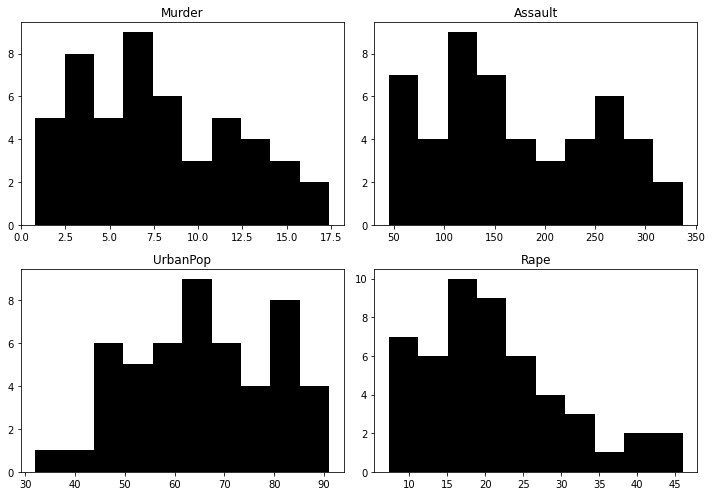

In [8]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(10, 7)) 
plt.tight_layout()
plt.show()

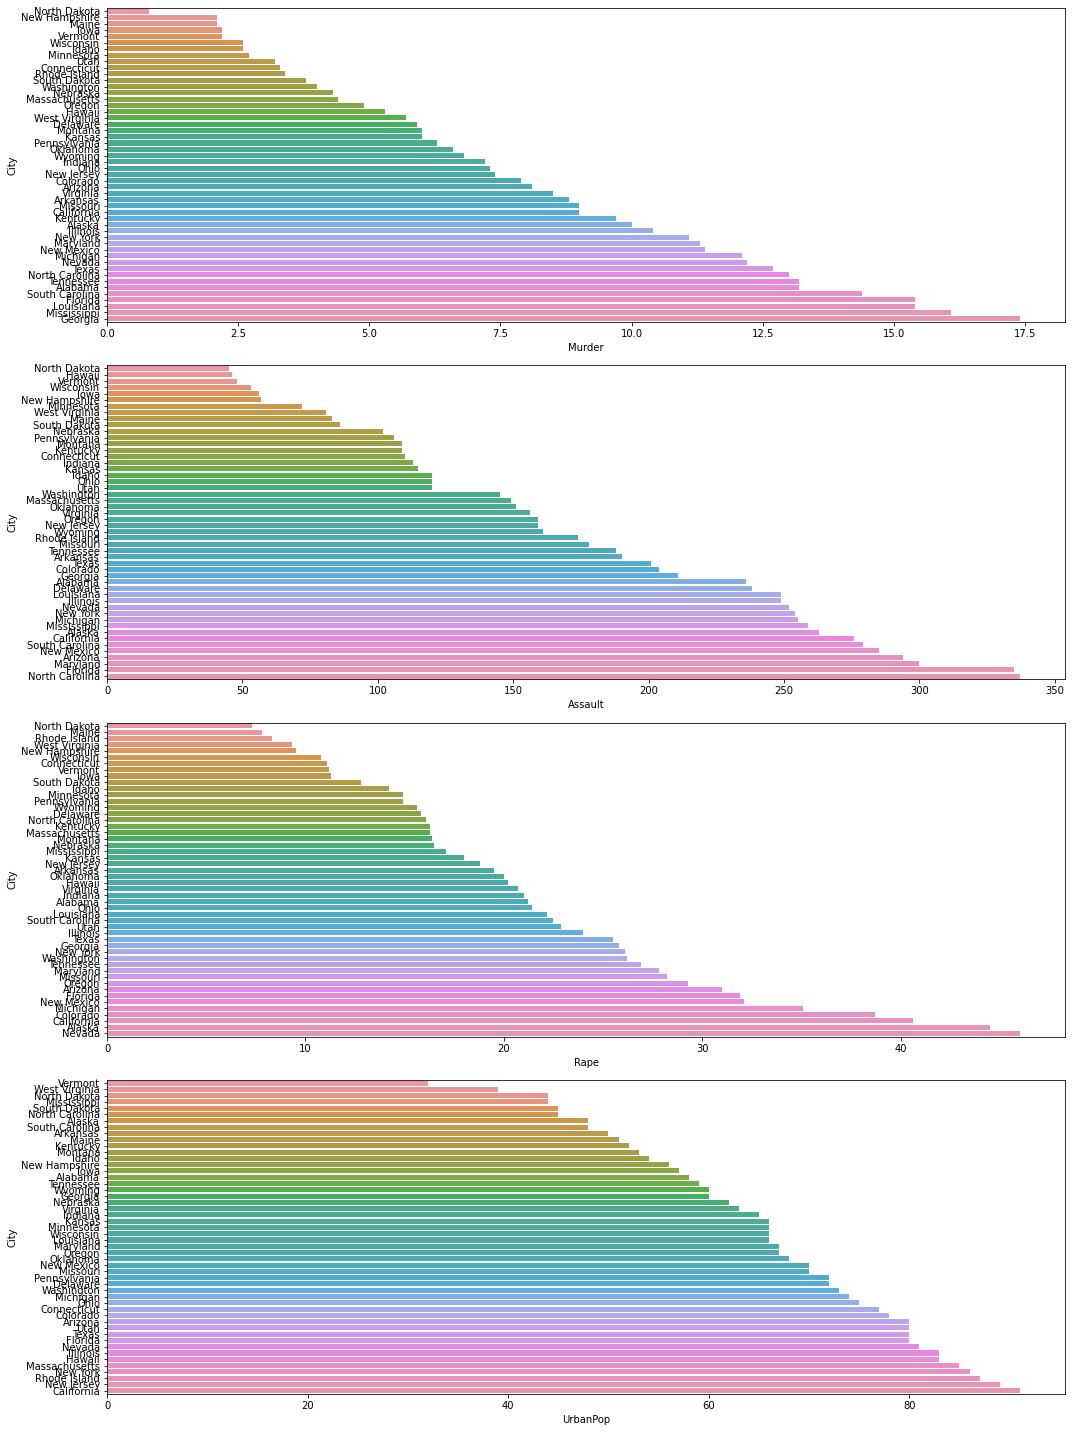

In [9]:
# create bar plots for all features
fix, ax = plt.subplots(4,1, figsize=(15,20))
sns.barplot(x='Murder', y=df.index, data=df, order=df.sort_values('Murder').index, ax=ax[0])
sns.barplot(x='Assault', y=df.index, data=df, order=df.sort_values('Assault').index, ax=ax[1])
sns.barplot(x='Rape', y=df.index, data=df, order=df.sort_values('Rape').index, ax=ax[2])
sns.barplot(x='UrbanPop', y=df.index, data=df, order=df.sort_values('UrbanPop').index, ax=ax[3])
plt.tight_layout()
plt.show()

The following States are the leaders in Murder, rape, assault and urban population:

Murder - Georgia and Mississippi

Assault -  Florida and North Carolina

Rape - Nevada and Alaska

Urban Pop - California and New Jersey

Compile the tabular information we have so far into a single dataframe:

In [10]:
# Create summary table
frames = [relevant_missing,selected_stats]
summary = pd.concat(frames, axis=1)
summary.rename(columns = {0:"missing"}, inplace = True)
summary.to_csv('summary.csv', index=True) 
summary


,missing,mean,std,min,max
Murder,0,7.788,4.355510,0.8,17.4
Assault,0,170.760,83.337661,45.0,337.0
UrbanPop,0,65.540,14.474763,32.0,91.0
Rape,0,21.232,9.366385,7.3,46.0


Looking at the data it is clear that Assault has the highest mean and standard deviation compared to the other variables. This is understandable because assault cases are not as severe as rape and murder. However, assault is also more common that rape and murder.

## Correlation Analysis

Correlation between the different columns was carried out with the  Pandas function, ``corr()``.

Seaborn's heatmap was used to display the correlations. A mask was applied to remove the top triangular half of correlations, as these mirrored the correlations that were kept.

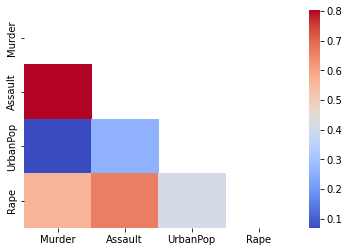

In [11]:
#Plot correlation heat map
corr_df = df.corr()
mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm")


In the plot, there is a linear correlation between strongly correlated variables: those coloured in dark red. 

All variables appear to be positively correlated: an increase in one corresponds to an increase in the other. In this case, the weaker the correlation, the darker the shade of blue.

From the correlation plot it is clear that there is a strong positive correlation between assault and murder, assault and rape and rape and murder. 

These make sense, as assault can be defined as a physical attack on a person. So, rape and murder can be considered as types of assault. The more one exists, the greater the chances of the other two existing.

A larger urban population size also increases the likelihood of rape cases.

While there is little to no correlation between the Urban population (UrbanPop) and murder. This is also understandable, as murders can occur anywhere and are not necessarily linked to how urban or rural a city is. There are other factors to consider, such as demographics, education, employment, etc. 

There are not many variables in this data set to begin with, however, the use of PCA can refine the variables further by removing similar variables and thus reducing the dimensions.



## Principal Component Analysis (PCA)

Principal Components Analysis (PCA) is a method for finding the variables (i.e. principal components) that best differentiate the observations by determining the directions along which your data points are most spread out (i.e. variance). PCA is a dimensionality reduction techinque which is useful when we have a lot of variables, and need to reduce them. 

### Standerdise data
Recall that Assault's std and mean were high. This will affect the results if left unchanged.

PCA is largely affected by scales and different features might have different scales. So it is better to standardize data before finding PCA components. This was done using Sklearn’s ```StandardScaler()``` function on the X variable.
This function removes the mean and scales to unit variance.

In [12]:
# Select columns for X variable
X = df.iloc[:,:].values.reshape(-1,4)

# Scale the X variable
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

# apply PCA
from sklearn.decomposition import PCA
pca = PCA()
X_std_trans = pca.fit_transform(X_std)

# display scaled PCA components in a data frame
df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.985566,1.133392,-0.444269,0.156267
1,1.950138,1.073213,2.040003,-0.438583
2,1.763164,-0.745957,0.054781,-0.834653
3,-0.141420,1.119797,0.114574,-0.182811
4,2.523980,-1.542934,0.598557,-0.341996


In [13]:
# create variables to be used in the biplot
cities = df.index
labels =corr_df.columns

In [14]:
def biplot(score,coeff,labels=None,points=None):
  xs = score[:,0]
  ys = score[:,1]
  n = coeff.shape[0]
  scalex = 1.0/(xs.max() - xs.min())
  scaley = 1.0/(ys.max() - ys.min())

  fig, ax = plt.subplots(figsize=(8,8))    

  ax.scatter(xs * scalex,ys * scaley,s=5)

  for i in range(0,len(xs)):
    txt = cities[i]
    ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

  for i in range(n):
    ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
    if labels is None:
      ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
    else:
      ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
  plt.xlabel("PC1")
  plt.ylabel("PC2")
  plt.grid()
 
 # Adapted from: Hyperiondev Course


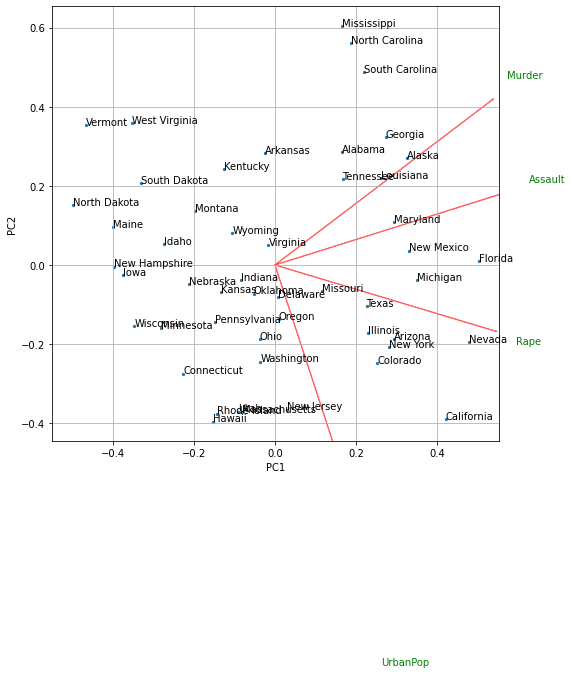

In [15]:
biplot(X_std_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels))
plt.show()

In [16]:
# Feature importance

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.535899,0.418181
1,Assault,0.583184,0.187986
2,UrbanPop,0.278191,0.872806
3,Rape,0.543432,0.167319


Inspecting the feature importance, we see that in PC1 most feature importance are spread out evenly. However, in PC2, UrbanPop has the highest importance.

## Component selection
Plotting a cumulative explained variance and scree plot can be used to determine how many components the data can be reduced to.

Text(0.5, 1.0, 'Cumulative Explained Variance')

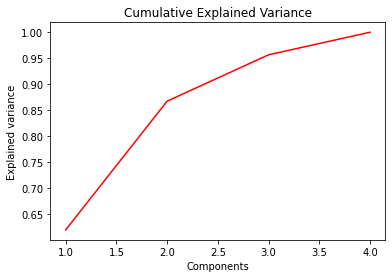

In [17]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

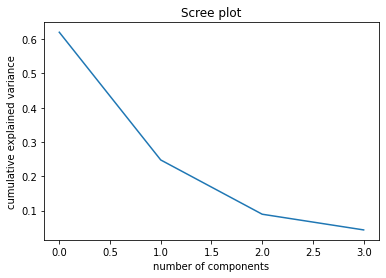

In [18]:
# Scree plot
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

After performing PCA it can be seen that the first 3 principal components together explain around 95% of the variance. This allows us to reduce the variables we have down to 3 from 4. We can therefore use them to perform cluster analysis. 

In [19]:
pca_df = pd.DataFrame(X_std_trans[:,0:3], index = df.index)
pca_df.head()

,0,1,2
City,,,
Alabama,0.985566,1.133392,-0.444269
Alaska,1.950138,1.073213,2.040003
Arizona,1.763164,-0.745957,0.054781
Arkansas,-0.141420,1.119797,0.114574
California,2.523980,-1.542934,0.598557


## Hierarchical clustering

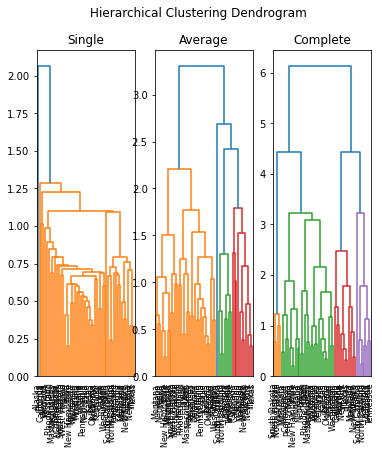

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6,6))
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
# Change the methods each time
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) 
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

Go with the complete dendrogram

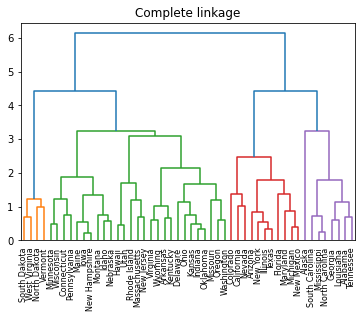

In [21]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

The complete dendrogram shows 4 clusters.

## K- means clustering

K-means clustering is a good way to separate data into distinct clusters. However, the number of cluster needs to be defined beforehand unlike with the hierarchical clustering that does not require that information in advance.

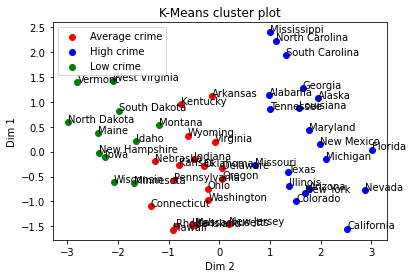

In [22]:
from sklearn.cluster import KMeans

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=3
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend(['Average crime', 'High crime', 'Low crime'], loc='best')

# Adapted from: Hyperiondev Course